Step 1.1: First 5 rows of dataset:
   Transaction_ID  Customer_ID Transaction_Date Transaction_Type Merchant  \
0               1          103       2025-01-01              ATM  BestBuy   
1               2          271       2025-01-01           Online     eBay   
2               3          107       2025-01-01              ATM   Amazon   
3               4           72       2025-01-01              POS   Amazon   
4               5          189       2025-01-01              ATM   Amazon   

        Category  Amount Payment_Mode Transaction_Status       Location  
0         Dining  360.10  Credit Card            Pending  San Francisco  
1         Travel  357.02  Credit Card           Declined        Chicago  
2  Entertainment  829.41  Credit Card            Pending        Chicago  
3      Groceries  790.35  Credit Card            Pending    Los Angeles  
4       Clothing  311.26  Credit Card           Declined  San Francisco  

Step 1.2: Dataset Shape: (1200, 10)

Step 1.3: Column Nam

C:\Users\comp\AppData\Local\Temp\ipykernel_2272\2133363103.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].median(), inplace=True)
C:\Users\comp\AppData\Local\Temp\ipykernel_2272\2133363103.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

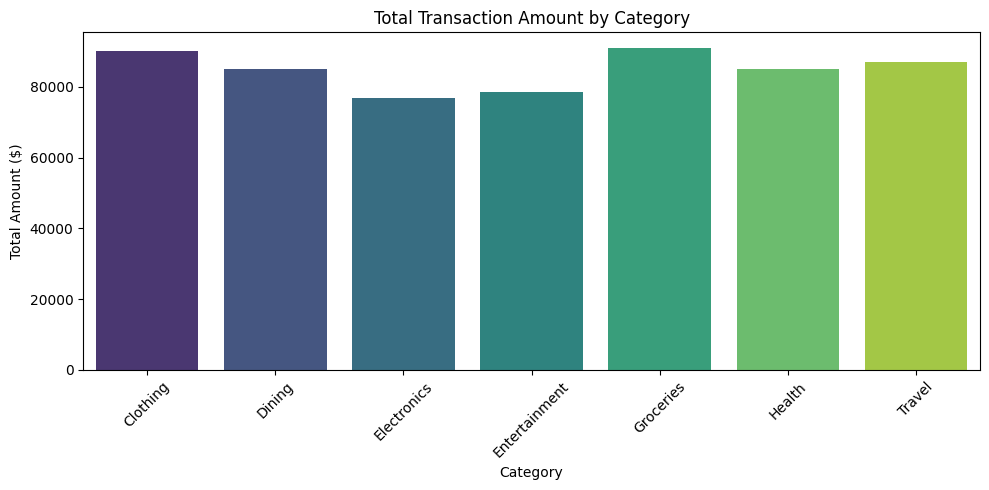

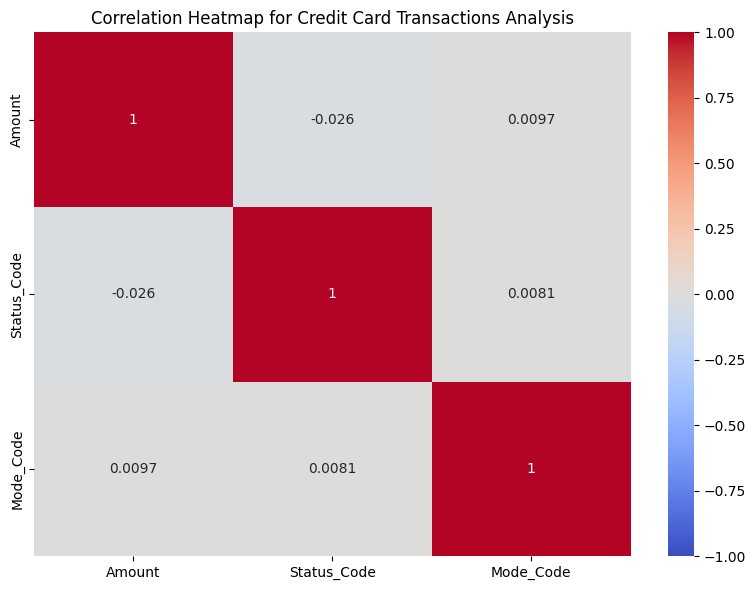

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Step 1: Load and Clean Data
# Load dataset
df = pd.read_csv('credit_card_transactions.csv')

# Show first 5 rows
print("Step 1.1: First 5 rows of dataset:")
print(df.head())

# Check dataset details
print("\nStep 1.2: Dataset Shape:", df.shape)
print("\nStep 1.3: Column Names:", df.columns.tolist())
print("\nStep 1.4: Summary Statistics:")
print(df.describe())

# Check for missing values
print("\nStep 1.5: Missing Values:")
print(df.isnull().sum())

# Fill missing values
for column in df.columns:
    if df[column].dtype == 'object':
        df[column].fillna('Unknown', inplace=True)
    else:
        df[column].fillna(df[column].median(), inplace=True)

# Verify no missing values
print("\nStep 1.6: Missing Values After Cleaning:")
print(df.isnull().sum())

# Convert Transaction_Date to datetime
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'], errors='coerce')
df['Year'] = df['Transaction_Date'].dt.year
df['Month'] = df['Transaction_Date'].dt.month
df['Day'] = df['Transaction_Date'].dt.day
print("\nStep 1.7: DataFrame Info After Date Conversion:")
print(df.info())

# Step 2: Filter Transactions
# January 2024 transactions
jan_2024 = df[(df['Year'] == 2024) & (df['Month'] == 1)]
print("\nStep 2.1: Transactions in January 2024:")
print(jan_2024.head())

# High-value online transactions
high_online = df[(df['Amount'] > 1000) & (df['Transaction_Type'] == 'Online')]
print("\nStep 2.2: Transactions Over $1000 (Online):")
print(high_online.head())

# Approved transactions
approved = df[df['Transaction_Status'] == 'Approved']
print("\nStep 2.3: Approved Transactions:")
print(approved.head())

# Step 3: Create New Features
# Add Discounted_Amount (5% off for >$500)
df['Discounted_Amount'] = df['Amount'].apply(lambda x: x * 0.95 if x > 500 else x)
print("\nStep 3.1: First 5 Rows with Discounted_Amount:")
print(df[['Amount', 'Discounted_Amount']].head())

# Categorize Amount
df['Amount_Category'] = pd.cut(df['Amount'], 
                              bins=[-float('inf'), 100, 500, float('inf')],
                              labels=['Low', 'Medium', 'High'])
print("\nStep 3.2: First 5 Rows with Amount_Category:")
print(df[['Amount', 'Amount_Category']].head())

# Drop Merchant if >30% missing
if df['Merchant'].isnull().mean() > 0.3:
    df.drop(columns=['Merchant'], inplace=True)
    print("\nStep 3.3: Dropped Merchant column (too many missing values).")
else:
    print("\nStep 3.3: Merchant column retained.")

# Step 4: Aggregate Data
# Total amount by category
total_by_category = df.groupby('Category')['Amount'].sum().reset_index()
print("\nStep 4.1: Total Amount by Category:")
print(total_by_category)

# Declined transactions by payment mode
declined_by_mode = df[df['Transaction_Status'] == 'Declined'].groupby('Payment_Mode').size().reset_index(name='Declined_Count')
print("\nStep 4.2: Declined Transactions by Payment Mode:")
print(declined_by_mode)

# Top 5 merchants
if 'Merchant' in df.columns:
    top_merchants = df['Merchant'].value_counts().head(5).reset_index()
    top_merchants.columns = ['Merchant', 'Transaction_Count']
    print("\nStep 4.3: Top 5 Merchants:")
    print(top_merchants)
else:
    print("\nStep 4.3: Merchant column not available.")

# Average amount by location
avg_by_location = df.groupby('Location')['Amount'].mean().reset_index()
print("\nStep 4.4: Average Amount by Location:")
print(avg_by_location)

# Step 5: Detect Fraud
# Customers with >10 transactions daily
df['Date'] = df['Transaction_Date'].dt.date
daily_transactions = df.groupby(['Customer_ID', 'Date']).size().reset_index(name='Transaction_Count')
fraud_customers = daily_transactions[daily_transactions['Transaction_Count'] > 10]
print("\nStep 5.1: Customers with >10 Daily Transactions:")
print(fraud_customers)

# Same customer, different locations within 5 minutes
df_sorted = df.sort_values(['Customer_ID', 'Transaction_Date'])
df_sorted['Time_Diff'] = df_sorted.groupby('Customer_ID')['Transaction_Date'].diff().dt.total_seconds() / 60
df_sorted['Location_Change'] = df_sorted.groupby('Customer_ID')['Location'].shift() != df_sorted['Location']
location_anomalies = df_sorted[(df_sorted['Time_Diff'].notnull()) & (df_sorted['Time_Diff'] <= 5) & (df_sorted['Location_Change'])]
print("\nStep 5.2: Same Customer, Different Locations (5 Min):")
print(location_anomalies[['Customer_ID', 'Transaction_Date', 'Location', 'Time_Diff']])

# High-risk transactions (> $5000, Online)
high_risk = df[(df['Amount'] > 5000) & (df['Transaction_Type'] == 'Online')]
print("\nStep 5.3: High-Risk Transactions (> $5000, Online):")
print(high_risk)

# Step 6: Merge with Customer Data
try:
    customer_info = pd.read_csv('customer_info.csv')
    merged_df = pd.merge(df, customer_info, on='Customer_ID', how='inner')
    age_bins = [0, 18, 30, 50, 100]
    age_labels = ['<18', '18-30', '31-50', '>50']
    merged_df['Age_Group'] = pd.cut(merged_df['Age'], bins=age_bins, labels=age_labels, include_lowest=True)
    avg_by_age = merged_df.groupby('Age_Group')['Amount'].mean().reset_index()
    print("\nStep 6.1: Average Amount by Age Group:")
    print(avg_by_age)
except FileNotFoundError:
    print("\nStep 6.1: customer_info.csv not found.")

# Step 7: Visualize Insights
# Bar chart: Total amount by category
plt.figure(figsize=(10, 5))
sns.barplot(data=total_by_category, x='Category', y='Amount', palette='viridis')
plt.title('Total Transaction Amount by Category')
plt.xlabel('Category')
plt.ylabel('Total Amount ($)')
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig('bar_chart_category.png', bbox_inches='tight')
plt.show()

# Heatmap: Correlation
df_encoded = df.copy()
df_encoded['Status_Code'] = df_encoded['Transaction_Status'].astype('category').cat.codes
df_encoded['Mode_Code'] = df_encoded['Payment_Mode'].astype('category').cat.codes
correlation_matrix = df_encoded[['Amount', 'Status_Code', 'Mode_Code']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap for Credit Card Transactions Analysis')
plt.tight_layout()
#plt.savefig('heatmap_correlation.png', bbox_inches='tight')
plt.show()